In [2]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.4 MB/s eta 0:00:00


Epoch: 001, Loss: 1.9527, Train Acc: 0.5929, Val Acc: 0.4860, Test Acc: 0.5130
Epoch: 002, Loss: 1.8578, Train Acc: 0.8000, Val Acc: 0.6020, Test Acc: 0.6300
Epoch: 003, Loss: 1.7434, Train Acc: 0.8429, Val Acc: 0.7040, Test Acc: 0.6890
Epoch: 004, Loss: 1.6040, Train Acc: 0.8571, Val Acc: 0.7180, Test Acc: 0.7200
Epoch: 005, Loss: 1.4529, Train Acc: 0.9071, Val Acc: 0.7300, Test Acc: 0.7410
Epoch: 006, Loss: 1.2997, Train Acc: 0.9286, Val Acc: 0.7300, Test Acc: 0.7600
Epoch: 007, Loss: 1.1544, Train Acc: 0.9286, Val Acc: 0.7460, Test Acc: 0.7690
Epoch: 008, Loss: 1.0163, Train Acc: 0.9500, Val Acc: 0.7480, Test Acc: 0.7790
Epoch: 009, Loss: 0.8842, Train Acc: 0.9643, Val Acc: 0.7480, Test Acc: 0.7820
Epoch: 010, Loss: 0.7603, Train Acc: 0.9714, Val Acc: 0.7480, Test Acc: 0.7810
Epoch: 011, Loss: 0.6473, Train Acc: 0.9786, Val Acc: 0.7540, Test Acc: 0.7860
Epoch: 012, Loss: 0.5470, Train Acc: 0.9786, Val Acc: 0.7580, Test Acc: 0.7830
Epoch: 013, Loss: 0.4595, Train Acc: 0.9857, Val Acc

<ipython-input-5-cb9be3cfc698>:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(G, node_color=color_map, with_labels=True, node_size=50, font_size=5, font_color='black', cmap=plt.cm.get_cmap('Set1'))


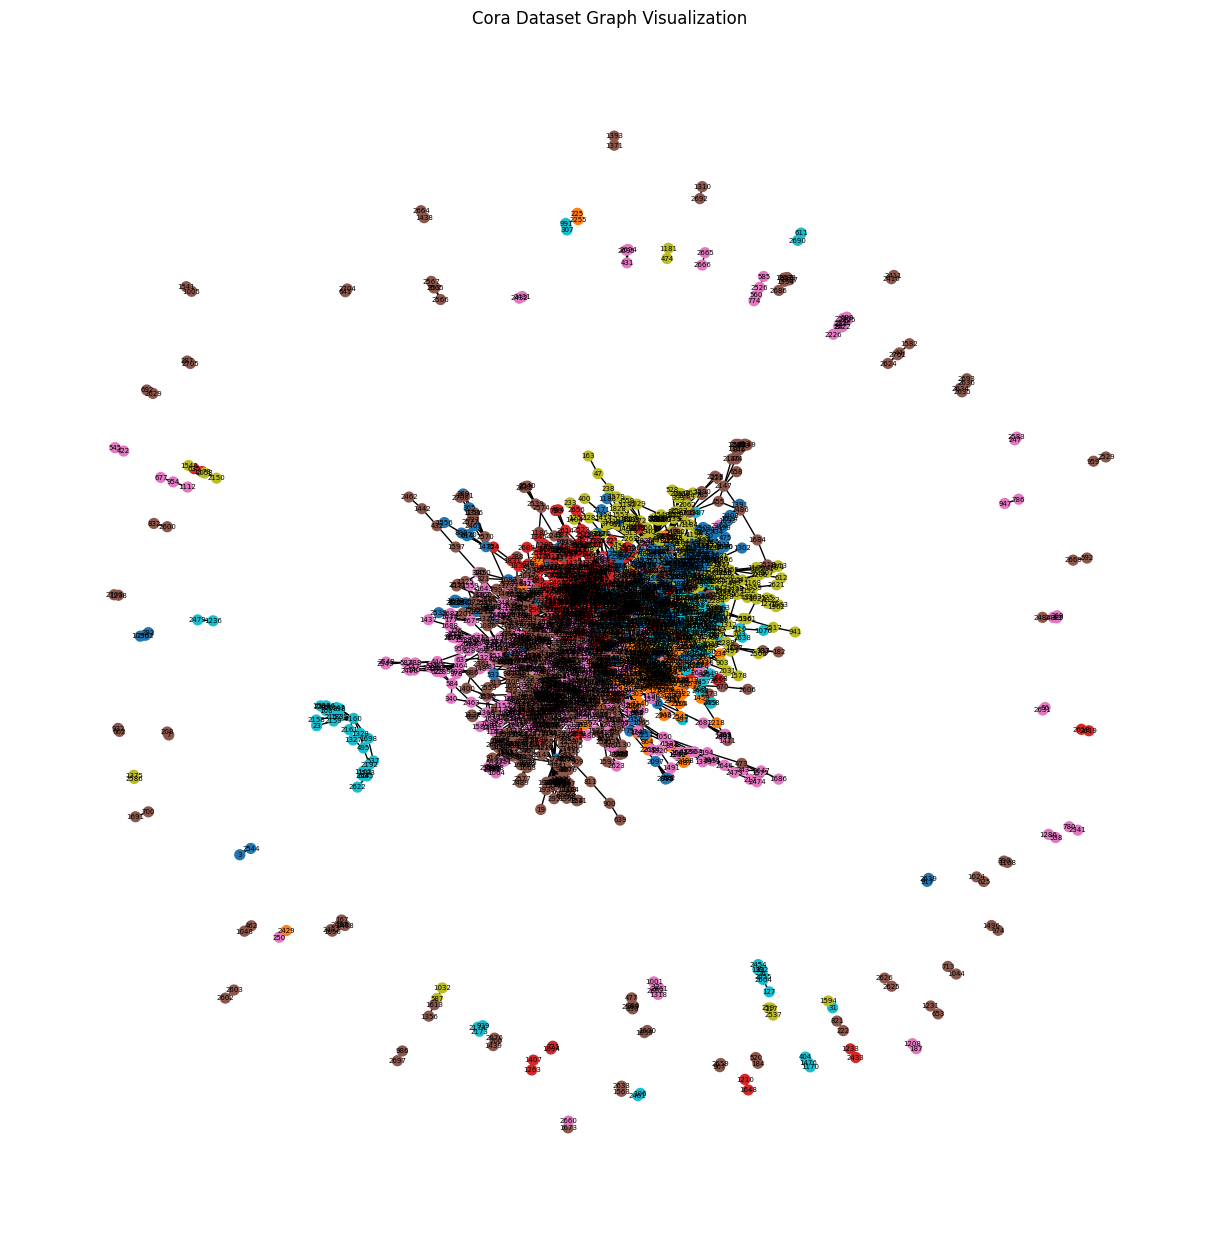

In [5]:
# Import necessary libraries
# torch: for tensor operations and neural network functionalities
# torch_geometric: for working with graph data and neural networks designed for graph data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# Section 1: Loading the Cora Dataset
# The Planetoid dataset class loads the Cora dataset.
# Cora is a citation network, where nodes represent research papers and edges represent citation relationships.
# The goal is to classify each paper (node) into one of 7 research topics.
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Access the data from the dataset
# The dataset contains only one graph, accessed via dataset[0].
data = dataset[0]

# Section 2: Building the GCN Model
# GCN (Graph Convolutional Network) is designed for graph data.
# It learns node representations by aggregating information from neighboring nodes.
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        # GCNConv layers perform graph convolution
        # First layer transforms input features to a hidden representation of size 16
        self.conv1 = GCNConv(dataset.num_features, 16)
        # Second layer outputs the final representation of size equal to the number of classes (7 in this case)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        # Perform first graph convolution and apply ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Perform second graph convolution for the final node predictions
        x = self.conv2(x, edge_index)
        # Apply log-softmax for multi-class classification output
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Section 3: Training the GCN Model
# The training loop runs for 200 epochs to optimize the model's weights.
def train():
    model.train()
    optimizer.zero_grad()  # Reset gradients
    out = model(data.x, data.edge_index)  # Forward pass
    # Calculate the loss for training nodes only
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()  # Backpropagate gradients
    optimizer.step()  # Update model weights
    return loss.item()

# Section 4: Testing the Model
# Evaluates the model on the test set to check its accuracy.
def test():
    model.eval()
    out = model(data.x, data.edge_index)  # Forward pass for all nodes
    # Get the predictions by finding the class with the highest score for each node
    pred = out.argmax(dim=1)
    # Calculate accuracy on training, validation, and test masks
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

# Training the model for 200 epochs and displaying the loss
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
print(f'\nFinal Test Accuracy: {test_acc:.4f}')
# Section 5: Visualizing the Graph
# Convert the graph data to NetworkX format for visualization
G = to_networkx(data, to_undirected=True)

# Set the figure size for the plot
plt.figure(figsize=(12, 12))

# Get the node labels (ground truth) for coloring based on class
labels = data.y.numpy()

# Generate a color map for each class
color_map = [plt.cm.tab10(label / max(labels)) for label in labels]

# Draw the graph using NetworkX with colors representing different classes
nx.draw(G, node_color=color_map, with_labels=True, node_size=50, font_size=5, font_color='black', cmap=plt.cm.get_cmap('Set1'))

# Set the title and display the plot
plt.title("Cora Dataset Graph Visualization")
plt.show()

# Section 6: Summary and Understanding the Results
# Our objective was to classify research papers (nodes) into one of seven topics using a GCN.
# The training accuracy indicates how well the model fits the training data,
# while the validation and test accuracy show how well the model generalizes to unseen data.
# With a test accuracy of around 81%, the GCN has successfully learned meaningful node representations.
# The visualization helps us understand the graph's structure and the node classifications.



Final Test Accuracy: 0.8050
